<h1>Spacial density of Na and K in various traps</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union

from astropy.constants import hbar, k_B

from quantum_statistics.spatial_basis import GridSpatialBasisSet

from quantum_statistics import (
    ParticleProps, 
    BoseGas, 
    FermiGas, 
    harmonic_trap,
    box_trap,
    box_2d_harmonic_1d_trap,
    ring_beam_trap,
    analyze_bec,
    analyze_fermi_gas,
    plot_condens_frac,
)

from scipy.optimize import line_search

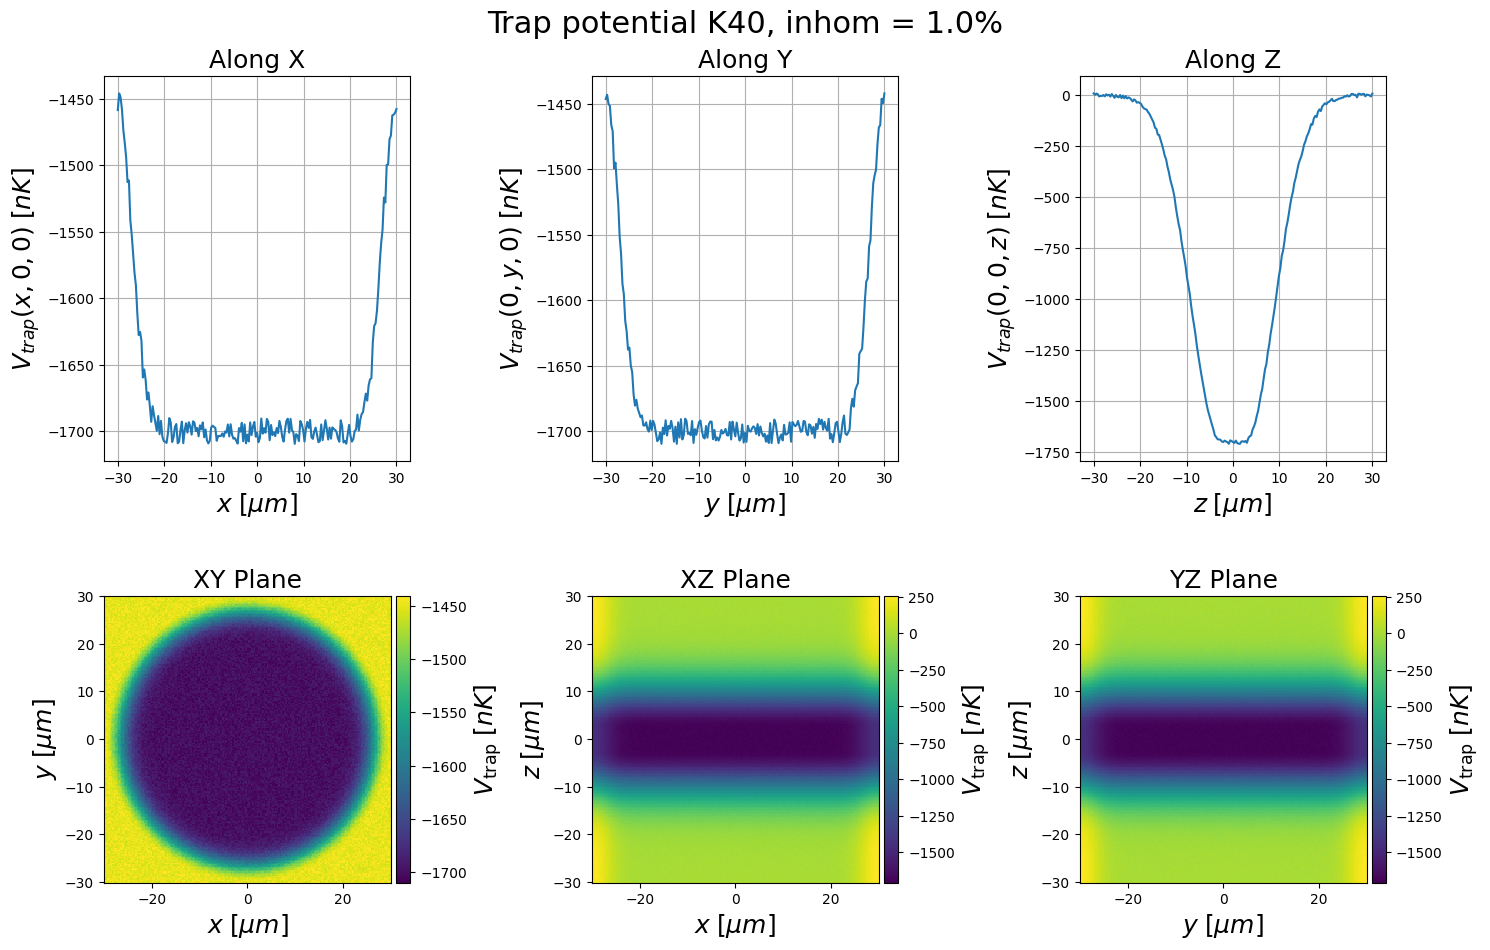

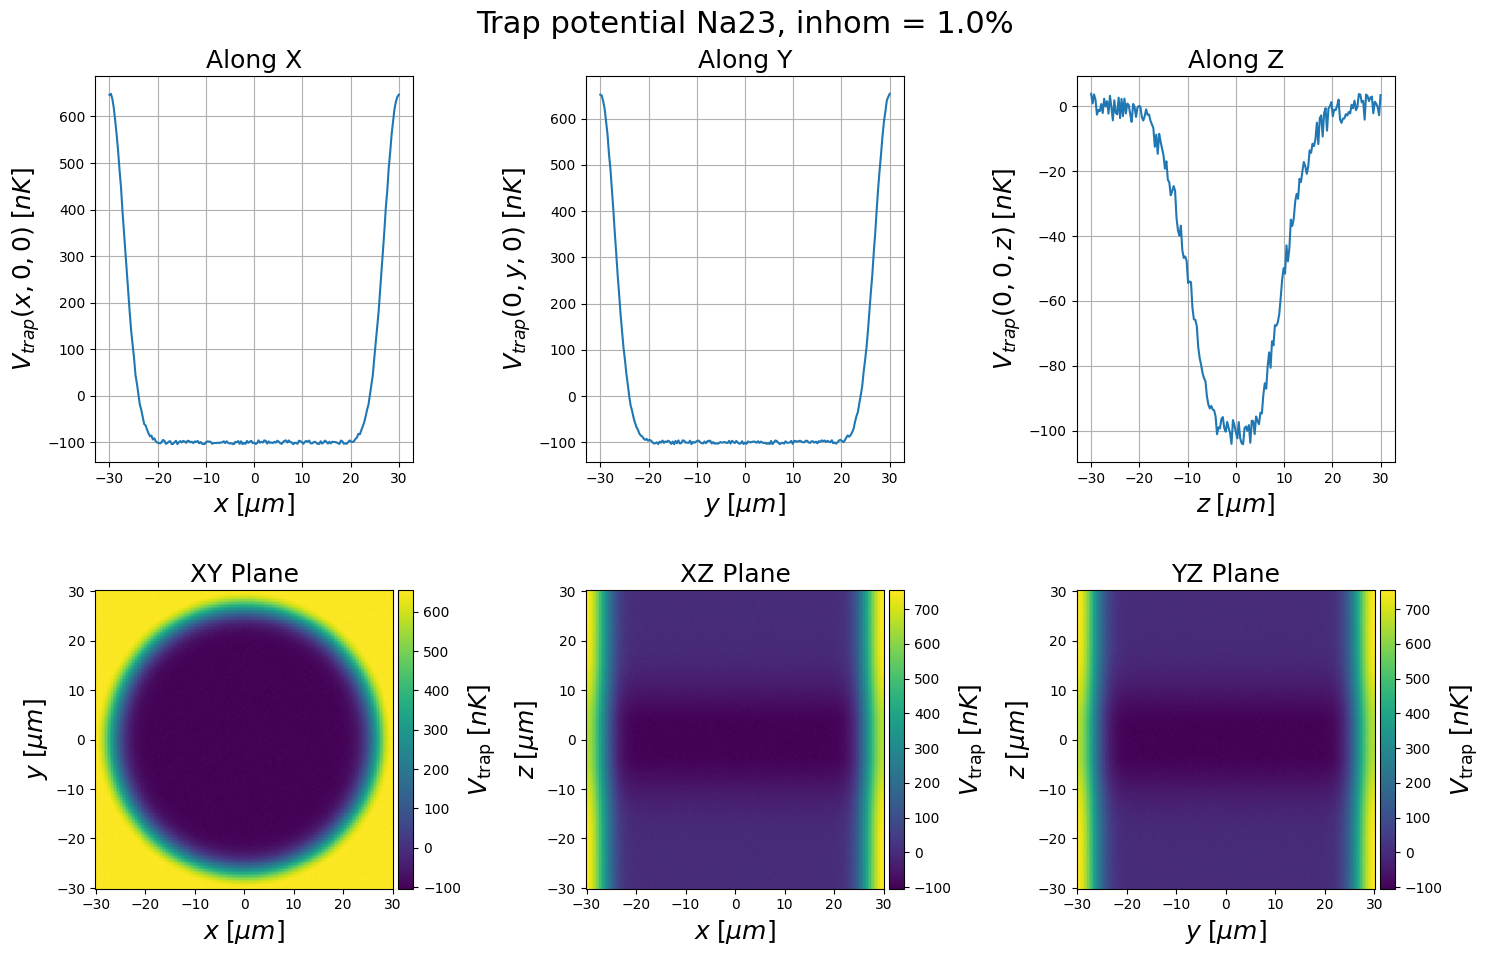

In [2]:
blue_trap_height_K = 250   # for Na: *3
red_trap_depth_K = 17*100 # for Na: /17
inhom = 0.01

k40 = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=100000,
    T=0, #45*u.nK,
    domain=(-30, 30)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=17*100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    blue_trap_height=blue_trap_height_K,
    red_trap_depth=red_trap_depth_K,
    inhomogeneity=inhom,
)

na23 = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=100000,
    T=0, #15*u.nK,
    a_s=2.75*u.nm,
    domain=(-30, 30)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    blue_trap_height=3*blue_trap_height_K,
    red_trap_depth=red_trap_depth_K/17,
    inhomogeneity=inhom,
)

k40.plot_V_trap(title="Trap potential K40, inhom = " + str(k40.inhomogeneity*100) + "%", filename="./plots/20240130_trap_potential_K40_" + str(k40.inhomogeneity*100) + ".png")
na23.plot_V_trap(title="Trap potential Na23, inhom = " + str(na23.inhomogeneity*100) + "%", filename="./plots/20240130_trap_potential_Na23_" + str(na23.inhomogeneity*100) + ".png")

In [3]:
fg = FermiGas(k40)
fg.eval_density(use_TF_or_LDA=False)

Initial n is calculated with the Thomas-Fermi approximation, then functional energy minimization is used.


  6%|▌         | 55/1000 [00:01<00:34, 27.10it/s]

Initialization done. Now using energy functional minimization.


  6%|▌         | 55/1000 [00:15<04:23,  3.59it/s]

Convergence reached after 55 iterations.


In [4]:
bg = BoseGas(na23)
bg.eval_density(use_TF=False)

Initial n0 is calculated with the Thomas-Fermi approximation, then functional energy minimization is used.


 49%|████▉     | 49/100 [00:02<00:02, 22.58it/s]

Initialization done. Now using energy functional minimization.


 49%|████▉     | 49/100 [00:11<00:12,  4.15it/s]

Convergence reached after 49 iterations.


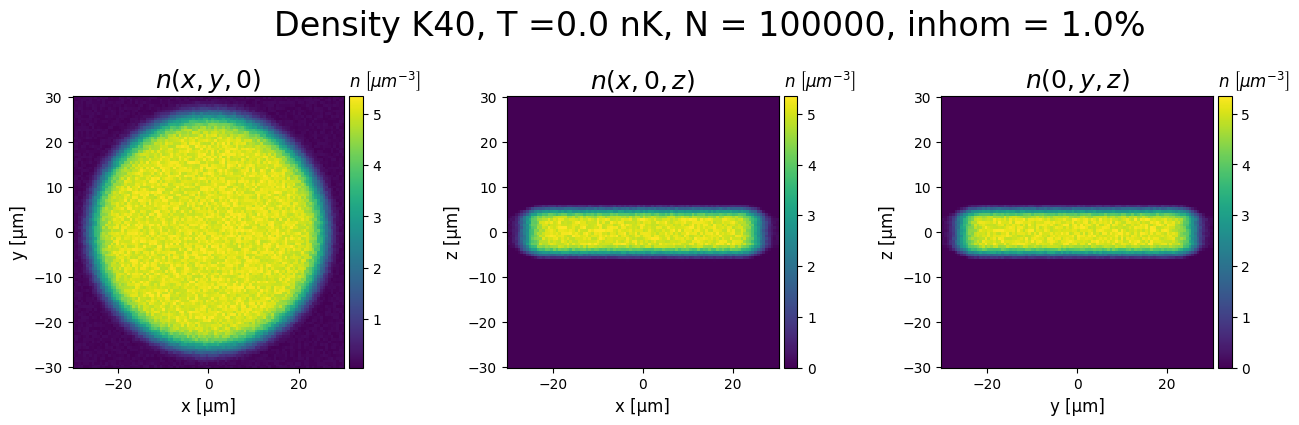

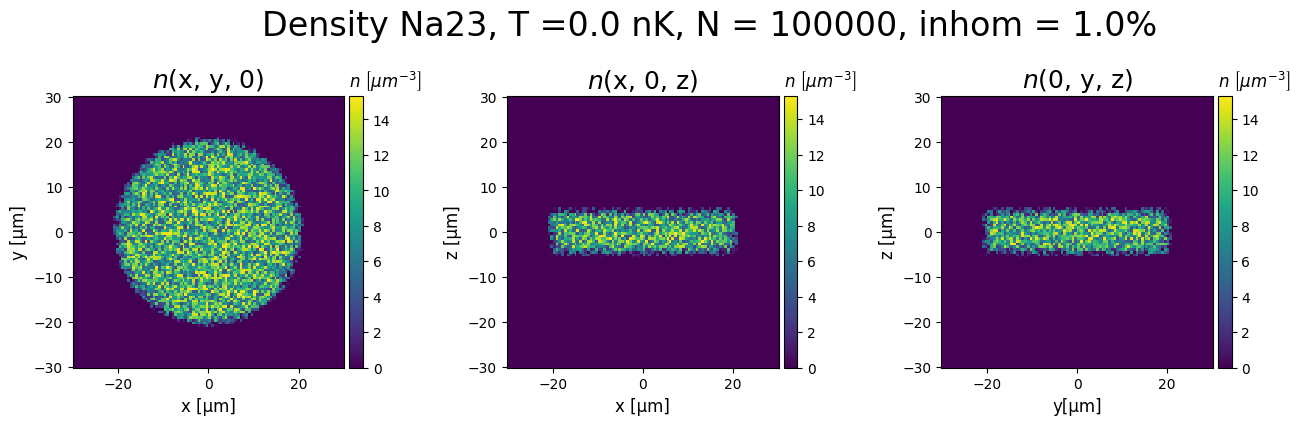

In [5]:
fg.plot_density_2d(title="Density K40, T =" + k40.T.__str__() + ", N = " + k40.N_particles.__str__() + ", inhom = " + str(k40.inhomogeneity*100) + "%", filename="./plots/20240130_K40_2d_" + str(k40.inhomogeneity*100) + ".png")
bg.plot_density_2d('n', title="Density Na23, T =" + na23.T.__str__() + ", N = " + na23.N_particles.__str__() + ", inhom = " + str(na23.inhomogeneity*100) + "%", filename="./plots/20240130_Na23_2d_" + str(na23.inhomogeneity*100) + ".png")

In [6]:
num_points = 201

x = np.linspace(fg.particle_props.domain[0, 0].value, fg.particle_props.domain[0, 1].value, num_points)
y = np.linspace(fg.particle_props.domain[1, 0].value, fg.particle_props.domain[1, 1].value, num_points)
z = np.linspace(fg.particle_props.domain[2, 0].value, fg.particle_props.domain[2, 1].value, num_points)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

fg_n = fg.spatial_basis_set.expand_coeffs(fg.n_array, X, Y, Z)
bg_n = bg.spatial_basis_set.expand_coeffs(bg.n_array, X, Y, Z)

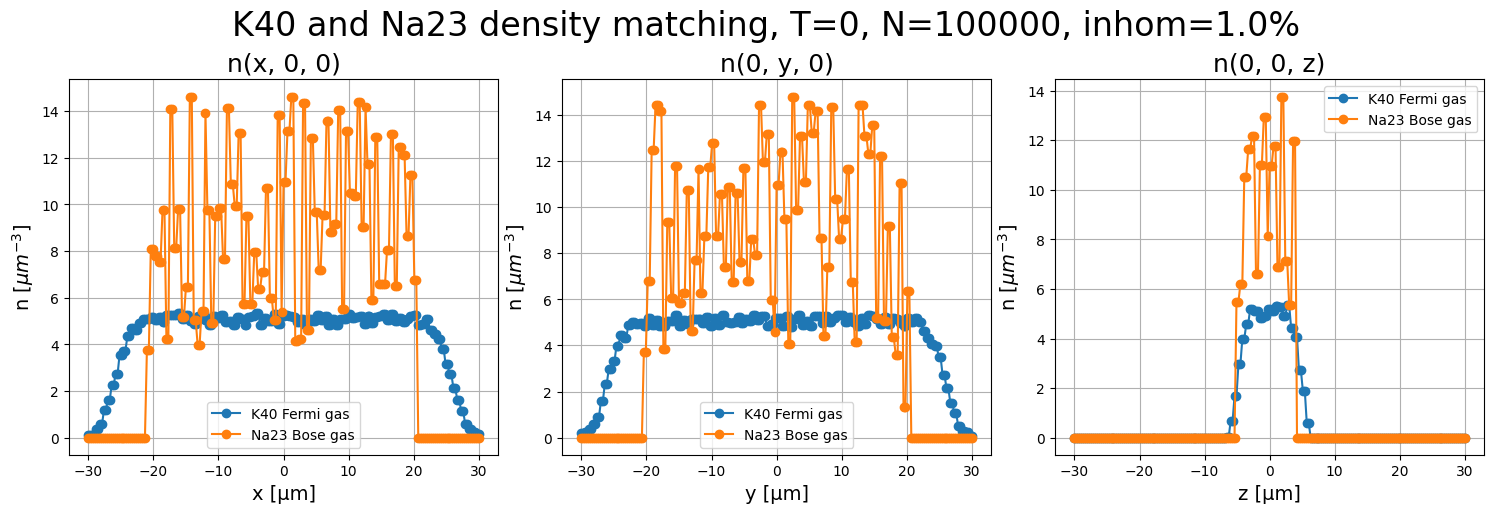

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('K40 and Na23 density matching, T=0, N=100000, inhom=' + str(k40.inhomogeneity*100) + "%", fontsize=24)
fig.tight_layout(pad=1.5)

axs[0].plot(x, fg_n[:, num_points//2, num_points//2], label='K40 Fermi gas', marker='o')
axs[0].plot(x, bg_n[:, num_points//2, num_points//2], label='Na23 Bose gas', marker='o')
axs[0].set_xlabel('x [μm]', fontsize=14)
axs[0].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
axs[0].set_title('n(x, 0, 0)', fontsize=18)
axs[0].legend()
axs[0].grid(True)

axs[1].plot(y, fg_n[num_points//2, :, num_points//2], label='K40 Fermi gas', marker='o')
axs[1].plot(y, bg_n[num_points//2, :, num_points//2], label='Na23 Bose gas', marker='o')
axs[1].set_xlabel('y [μm]', fontsize=14)
axs[1].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
axs[1].set_title('n(0, y, 0)', fontsize=18)
axs[1].legend()
axs[1].grid(True)

axs[2].plot(z, fg_n[num_points//2, num_points//2, :], label='K40 Fermi gas', marker='o')
axs[2].plot(z, bg_n[num_points//2, num_points//2, :], label='Na23 Bose gas', marker='o')
axs[2].set_xlabel('z [μm]', fontsize=14)
axs[2].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
axs[2].set_title('n(0, 0, z)', fontsize=18)
axs[2].legend()
axs[2].grid(True)

plt.savefig("./plots/20240130_density_matching_" + str(k40.inhomogeneity*100) + ".png", dpi=300, bbox_inches='tight')